# 프로젝트: 한국어 데이터로 챗봇 만들기
## 🎯 루브릭 평가
1. 한국어 전처리를 이용한 학습 데이터 구축
2. 트랜스포머 모델 구현
3. 한국어 입력문장에 한국어로 답변하는 함수 구현

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## 1. 데이터 수집하기
https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

#### 데이터 파악하기
* 챗봇 트레이닝용 문답 페어 11,876개
* 일상다반서 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

이번 프로젝트에서는 레이블링된 데이터는 사용하지 않을 것 같다.

In [18]:
data_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData.csv'
data_df = pd.read_csv(data_path, usecols=[0,1])

In [19]:
data_df.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [20]:
len(data_df)

11823

In [21]:
# null 값 확인
data_df.isnull().sum()

Q    0
A    0
dtype: int64

## 2. 데이터 전처리

In [22]:
!pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-60hoxs68
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [26]:
def preprocess_sentence(sentence):    
    # ... 같은 것은 삭제를 한다.
    sentence = re.sub(r'["."]{2,}', r"", sentence)  
    
    # 단어와 구두점(punctuation) 사이의 간격을 둬 구별한다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

전처리를 확인해보자.

In [27]:
text = "아마도그러지 않을까 싶은데 잘 모르겠네..."
preprocess_sentence(text)

'아마도그러지 않을까 싶은데 잘 모르겠네'

In [28]:
questions = []
for sentence in data_df['Q'].tolist():
    sentence = preprocess_sentence(sentence)
    sentence = sentence.strip()
    questions.append(sentence)
questions[:10]    

['12시 땡 !',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'PPL 심하네',
 'SD카드 망가졌어',
 'SD카드 안돼',
 'SNS 맞팔 왜 안하지ㅠㅠ',
 'SNS 시간낭비인 거 아는데 매일 하는 중',
 'SNS 시간낭비인데 자꾸 보게됨']

In [29]:
answers = []
for sentence in data_df['A'].tolist():
    sentence = preprocess_sentence(sentence)
    sentence = sentence.strip()
    answers.append(sentence)
answers[:10]    

['하루가 또 가네요 .',
 '위로해 드립니다 .',
 '여행은 언제나 좋죠 .',
 '여행은 언제나 좋죠 .',
 '눈살이 찌푸려지죠 .',
 '다시 새로 사는 게 마음 편해요 .',
 '다시 새로 사는 게 마음 편해요 .',
 '잘 모르고 있을 수도 있어요 .',
 '시간을 정하고 해보세요 .',
 '시간을 정하고 해보세요 .']

In [30]:
len(questions), len(answers)

(11823, 11823)

In [31]:
# clear_data_df=pd.DataFrame({'Q':questions, 'A':answers})

In [32]:
# temp_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/after_clear_data.csv'

In [33]:
# 파일을 임시 저장
# clear_data_df.to_csv(temp_path, index=False)

In [34]:
# clear_data_df = pd.read_csv(temp_path)
# clear_data_df.head()

In [35]:
# questions = clear_data_df['Q'].tolist()
# answers = clear_data_df['A'].tolist()
# len(questions), len(answers)

## 3. SubwordTextEncoder 사용하기
병렬 데이터 전처리 하기

In [36]:
# 단어장 만들기
temp_data = questions+answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [37]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8171]
END_TOKEN의 번호 : [8172]


In [38]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8173


Q와 A의 길이 시각화

In [39]:
len_q = [len(i) for i in questions]
len_a = [len(i) for i in answers]

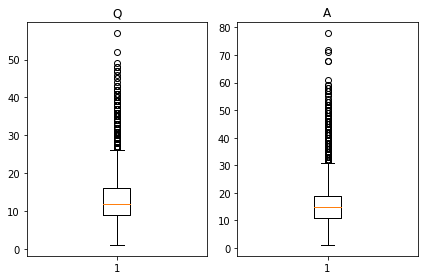

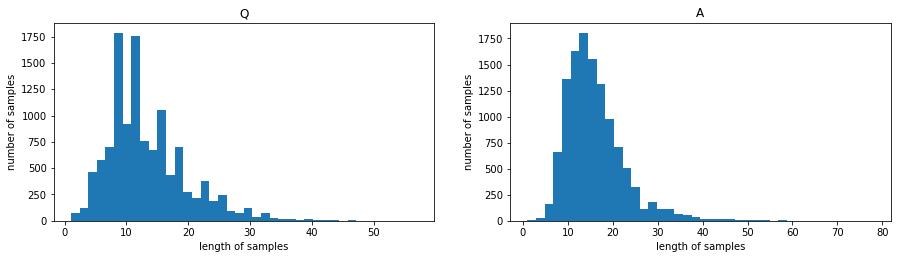

In [40]:
plt.subplot(1,2,1)
plt.boxplot(len_q)
plt.title('Q')
plt.subplot(1,2,2)
plt.boxplot(len_a)
plt.title('A')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.title('Q')
plt.hist(len_q, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(2,2,2)
plt.title('A')
plt.hist(len_a, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [41]:
print('Q의 최소 길이 : {}'.format(np.min(len_q)))
print('Q의 최대 길이 : {}'.format(np.max(len_q)))
print('Q의 평균 길이 : {}'.format(np.mean(len_q)))
print('A의 최소 길이 : {}'.format(np.min(len_a)))
print('A의 최대 길이 : {}'.format(np.max(len_a)))
print('A의 평균 길이 : {}'.format(np.mean(len_a)))

Q의 최소 길이 : 1
Q의 최대 길이 : 57
Q의 평균 길이 : 13.231582508669542
A의 최소 길이 : 1
A의 최대 길이 : 78
A의 평균 길이 : 16.0336631988497


위의 결과를 참고해서 문장의 최대 길이는 40으로 설정한다.

In [42]:
MAX_LENGTH = 40

In [43]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [44]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8173
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### Teacher forcing

In [45]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

In [46]:
# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

## 4. 모델 구성하기

#### Positional Encoding

In [47]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


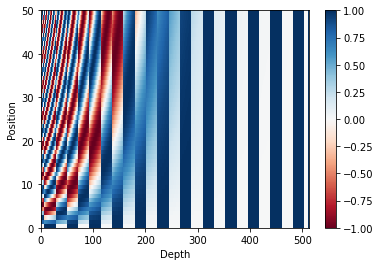

In [48]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Scaled Dot Product Attention
단어 벡터간 유사도를 구해 특정 분모로 나눠준다.

![image](https://user-images.githubusercontent.com/63278762/132636921-cd16e56b-050a-43bb-a8cb-2109fefc4bdf.png)

In [49]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

#### 멀티헤드 어텐션
![image](https://user-images.githubusercontent.com/63278762/132632598-23098cdb-adb3-4411-92dc-b1184b5af2e2.png)

In [50]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. Q, K, V에 각각의 Dense층을 지나게 한다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 지정된 num_heads만큼 나눈다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 나누어졌던 헤드들을 연결
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 5. 최종 결과도 WO 층을 지나게 한다.
        outputs = self.dense(concat_attention)

        return outputs

#### 마스킹

In [51]:
# 패딩 마스킹 : 패딩 토큰의 인덱스인지 아닌지를 판별
# 0->1, 0이 아니면->0
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [52]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [53]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [54]:
print(create_look_ahead_mask(tf.constant([[2,0,1,6]])))

tf.Tensor(
[[[[0. 1. 1. 1.]
   [0. 1. 1. 1.]
   [0. 1. 0. 1.]
   [0. 1. 0. 0.]]]], shape=(1, 1, 4, 4), dtype=float32)


![image](https://user-images.githubusercontent.com/63278762/132450630-0b626695-a524-46ab-a267-8bb88b296d16.png)

* [Position-wise FFNN](https://wikidocs.net/45609) : 일반적인 피드 포워드 신경망

#### 인코더 정의

In [55]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # first sub layer : multi-head self-Attention
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })

    # 위 사진에서 첫번째 Add & Norm 부분
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # second sub layer : position-wise FFNN
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 위 사진에서 두번째 Add & Norm 부분
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [56]:
# 인코더 레이어를 쌓아 인코더 만들기
# 임배딩 레이어와 포지셔널 인코딩 레이어도 연결한다.
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 디코더의 정의

In [57]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    # 룩어헤드 마스크(first sub layer)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    # 패딩 마스크(second sub layer)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # first sub layer : multi-head self-attention
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 위 사진에서 첫번째 Add & Norm 부분
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # second sub layer : encoder-decoder attention
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 위 사진에서 두번째 Add & Norm 부분
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # third sub layer : position-wise FFNN
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 위 사진에서 세번째 Add & Norm 부분
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [58]:
# 디코더 레이어를 쌓아 디코더 만들기
# 임배당 레이어와 포지셔널 인코딩 레이어도 연결한다.
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

#### transformer 정의

In [59]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [60]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

In [61]:
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146496     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### loss function
* 레이블에 패딩이 되어있으므로 loss를 계산할 때도 패딩 마스크를 적용.
* 다중 분류 문제이므로 Crossentropy 사용

In [62]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### custom learning rate scheduling
초기에 learning rate를 급격하게 높였다가, 이후 서서히 낮추는 것. warmup_steps으로 4000을 사용
$$\Large{lrate = d_{model}^{-0.5} × min(\text{step_num}^{-0.5},\ \text{step_num} × \text{warmup_steps}^{-1.5})}$$

In [63]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

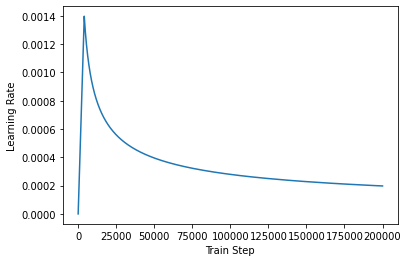

In [64]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 모델 컴파일

In [65]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 훈련하기

In [66]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 101s 512ms/step - loss: 1.4561 - accuracy: 0.0208
Epoch 2/20
185/185 [==============================] - 94s 511ms/step - loss: 1.1789 - accuracy: 0.0489
Epoch 3/20
185/185 [==============================] - 94s 508ms/step - loss: 1.0062 - accuracy: 0.0506
Epoch 4/20
185/185 [==============================] - 94s 508ms/step - loss: 0.9288 - accuracy: 0.0545
Epoch 5/20
185/185 [==============================] - 94s 508ms/step - loss: 0.8692 - accuracy: 0.0578
Epoch 6/20
185/185 [==============================] - 94s 506ms/step - loss: 0.8086 - accuracy: 0.0620
Epoch 7/20
185/185 [==============================] - 94s 507ms/step - loss: 0.7428 - accuracy: 0.0680
Epoch 8/20
185/185 [==============================] - 94s 507ms/step - loss: 0.6707 - accuracy: 0.0757
Epoch 9/20
185/185 [==============================] - 94s 506ms/step - loss: 0.5919 - accuracy: 0.0842
Epoch 10/20
185/185 [==============================] - 94s 507ms/step - 

## 5. 모델 평가하기

In [67]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [68]:
def predict(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [69]:
predict("소풍가고 싶어")

Input: 소풍가고 싶어
Output: 썸 고르는 것도 좋을 거 같아요 .


'썸 고르는 것도 좋을 거 같아요 .'

In [70]:
predict("목이 너무 아파")

Input: 목이 너무 아파
Output: 가끔씩 스트레칭을 해주세요 .


'가끔씩 스트레칭을 해주세요 .'

In [71]:
predict("우리 오빠가 너무 많이 고생하고 있다.")

Input: 우리 오빠가 너무 많이 고생하고 있다.
Output: 이별이 만든 허상일 수도 있어요 .


'이별이 만든 허상일 수도 있어요 .'

## 성능 개선

In [72]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

In [73]:
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5254912     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [75]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [76]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 226s 1s/step - loss: 1.1537 - accuracy: 0.0256
Epoch 2/20
185/185 [==============================] - 208s 1s/step - loss: 1.0926 - accuracy: 0.0274
Epoch 3/20
185/185 [==============================] - 207s 1s/step - loss: 1.0690 - accuracy: 0.0286
Epoch 4/20
185/185 [==============================] - 206s 1s/step - loss: 1.0601 - accuracy: 0.0289
Epoch 5/20
185/185 [==============================] - 206s 1s/step - loss: 1.0548 - accuracy: 0.0290
Epoch 6/20
185/185 [==============================] - 207s 1s/step - loss: 1.0509 - accuracy: 0.0289
Epoch 7/20
185/185 [==============================] - 207s 1s/step - loss: 1.0481 - accuracy: 0.0291
Epoch 8/20
185/185 [==============================] - 207s 1s/step - loss: 1.0463 - accuracy: 0.0293
Epoch 9/20
185/185 [==============================] - 206s 1s/step - loss: 1.0446 - accuracy: 0.0292
Epoch 10/20
185/185 [==============================] - 206s 1s/step - loss: 1.0428 - accura

In [79]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [80]:
def predict(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [82]:
predict("왜 이상하게 나오는걸까?")

Input: 왜 이상하게 나오는걸까?
Output: 잘  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


'잘  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'

# 회고

## 배운 내용
* transformer에 대해서 배웠다.
* positional encoding에 대해서 배웠다.
* 모델 그림과 비교하면서 모댈을 설계하는 법을 배웠다.
* LearningRateSchedule이용한 custom learning rate를 만드는 방법을 배웠다.
* multi head attention에 대해서 배웠다.

## 느낀 점
* 드디어 챗봇에 대해서 배워서 신났다.
* 이루다를 보면서 학습하는 데이터에 따라 대답의 단어가 달라진다고 느꼈는데 여기서도 데이터가 심리상담 데이터이다보니 사용자의 말에 공감을 해주거나, 위로해주는 내용이 많았다.
* 다른 대화 주제를 갖는 챗봇도 만들어보고 싶다.

# Reference

* https://wikidocs.net/92961
* https://wikidocs.net/89786
* https://wikidocs.net/45609
* https://github.com/nawnoes/WellnessConversation-LanguageModel